# <center>Pipelining for Vehicle Sales</center>

In [138]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#pd.set_option('display.width', 1000)


In [139]:
df = pd.read_csv('car_prices.csv')

df.make = df.make.str.lower()

#replacing the whitespace inbetween with '-'
df.make = df.make.str.replace(' ', '-')

#replacing 'mercedes-b' with mercedes-benz
df.make = df.make.str.replace('mercedes-b','mercedes-benz')
df.make = df.make.str.replace('-benzenz','-benz')

# also from the above we notice that the word truck is mustly replaced by tk, so we need to replace it
df.make = df.make.str.replace('tk', 'truck')

#now lets drop all the NaN in the make column
df.dropna(subset=['make'], inplace=True)
df.body = df.body.str.lower()
df.body = df.body.str.replace(' ', '-')
df = df.dropna()
df = df.drop(columns=['saledate','vin'])
#df.interior.unique()
df['interior'] = df['interior'].replace('—',np.NaN)
df['color'] = df['color'].replace('—',np.NaN)
df.dropna(inplace=True)

In [151]:
df.interior.unique()
df['interior'] = df['interior'].replace('—',np.NaN)

array(['black', 'beige', 'tan', 'brown', '—', 'gray', 'burgundy', 'white',
       'silver', 'off-white', 'red', 'yellow', 'green', 'purple', 'blue',
       'orange', 'gold'], dtype=object)

In [152]:
df['interior'] = df['interior'].replace('—',np.NaN)

In [168]:
df['color'] = df['color'].replace('—',np.NaN)
df.dropna(inplace=True)

In [153]:
df.isnull().sum()

year               0
make               0
model              0
trim               0
body               0
transmission       0
state              0
condition          0
odometer           0
color              0
interior        9864
seller             0
mmr                0
sellingprice       0
dtype: int64

In [155]:
df.dropna(inplace=True)

In [156]:
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
dtype: int64

In [157]:
df.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr,sellingprice
0,2015,kia,Sorento,LX,suv,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0
1,2015,kia,Sorento,LX,suv,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0
2,2014,bmw,3 Series,328i SULEV,sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0
3,2015,volvo,S60,T5,sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0
4,2014,bmw,6 Series Gran Coupe,650i,sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 462461 entries, 0 to 558836
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          462461 non-null  int64  
 1   make          462461 non-null  object 
 2   model         462461 non-null  object 
 3   trim          462461 non-null  object 
 4   body          462461 non-null  object 
 5   transmission  462461 non-null  object 
 6   state         462461 non-null  object 
 7   condition     462461 non-null  float64
 8   odometer      462461 non-null  float64
 9   color         462461 non-null  object 
 10  interior      462461 non-null  object 
 11  seller        462461 non-null  object 
 12  mmr           462461 non-null  float64
 13  sellingprice  462461 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 52.9+ MB


In [159]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice'],
      dtype='object')

In [160]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.feature_eng(X)

    @staticmethod
    def feature_eng(df3):
        # engineering the numerical features that have interaction
        #1. odometer vs. mmr
        #2. mmr vs. condition
        df['odo_mmr'] = df['odometer'] * df['mmr'] 
        df['mmr_cond'] = df['mmr'] * df['condition']
        df['cond_odo'] = df['condition'] * df['odometer']
        return df3

In [161]:
numerical_cols = ['year','condition','odometer','mmr']

In [162]:
categorical_cols = ['make','model','trim','body','transmission','state','color','interior']

In [163]:
X = df.drop(columns=['sellingprice'])
y = df['sellingprice']

#splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [164]:
categorical_cols

['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior']

In [101]:
# Define preprocessing transformer for both numerical and categorical data

#using LabelEncoder

# Custom function to apply LabelEncoder
def label_encode_column(X, col):
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    return X

categorical_transformer = Pipeline(steps=[
    ('make_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'make')), ['make']),
    ('model_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'model')), ['model']),
    ('trim_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'trim')), ['trim']),
    ('body_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'body')), ['body']),
    ('transmission_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'transmission')), ['transmission']),
    ('state_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'state')), ['state']),
    ('color_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'color')), ['color']),
    ('interior_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'interior')), ['interior']),

])

numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [83]:
# Define preprocessing for categorical data
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [102]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

In [103]:
# Define preprocessing for feature engineering
numerical_transformer_feature_engineering = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering())
])


In [121]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[('make_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'make')), ['make']),
        ('model_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'model')), ['model']),
        ('trim_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'trim')), ['trim']),
        ('body_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'body')), ['body']),
        ('transmission_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'transmission')), ['transmission']),
        ('state_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'state')), ['state']),
        ('color_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'color')), ['color']),
        ('interior_encoder', FunctionTransformer(lambda X: label_encode_column(X, 'interior')), ['interior']),
        ('feat_eng',feature_engineering, X_train.columns),
        ('num', numerical_transformer, numerical_cols)
        
    ],remainder='passthrough')

In [122]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('make_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D940B40E0>),
                                 ['make']),
                                ('model_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D940B4900>),
                                 ['model']),
                                ('trim_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D9CE34A40>),
                                 ['trim']),
                                ('body_encoder',
                                 Fun...
                                ('interior_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D9CE35300>),
                                 ['interior']),
                                ('feat_eng', FeatureEngineering(),
                                 Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr'],
      dtype='object')),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['year', 'condition', 'odometer', 'mmr'])])

In [123]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('make_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D940B40E0>),
                                 ['make']),
                                ('model_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D940B4900>),
                                 ['model']),
                                ('trim_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D9CE34A40>),
                                 ['trim']),
                                ('body_encoder',
                                 Fun...
                                ('interior_encoder',
                                 FunctionTransformer(func=<function <lambda> at 0x0000021D9CE35300>),
                                 ['interior']),
                                ('feat_eng', FeatureEngineering(),
                                 Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr'],
      dtype='object')),
                                ('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['year', 'condition', 'odometer', 'mmr'])])

In [124]:
Linearmodel = LinearRegression()

In [125]:
# Create and evaluate the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Linearmodel)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('make_encoder',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000021D940B40E0>),
                                                  ['make']),
                                                 ('model_encoder',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000021D940B4900>),
                                                  ['model']),
                                                 ('trim_encoder',
                                                  FunctionTransformer(func=<function <lambda> at 0x0000021D9CE34A40...
                                                  FunctionTransformer(func=<function <lambda> at 0x0000021D9CE35300>),
                                                  ['interior']),
                                                 ('feat_eng',
                                                  FeatureEngineering(),
                                                  Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['year', 'condition',
                                                   'odometer', 'mmr'])])),
                ('classifier', LinearRegression())])

In [133]:
X_train.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,mmr
311415,2010,toyota,Corolla,LE,sedan,automatic,nc,39.0,113433.0,black,beige,santander consumer,6725.0
363056,2014,chevrolet,Sonic,LTZ,hatchback,automatic,il,4.0,11994.0,red,gray,gm remarketing,11900.0
288159,2007,dodge,Caliber,Base,wagon,automatic,ga,2.0,157170.0,red,gray,enterprise veh exchange/rental,2075.0
485331,2004,dodge,Grand Caravan,SE,minivan,automatic,fl,19.0,132456.0,silver,gray,autonation honda miami lakes,1675.0
381677,2010,volkswagen,CC,Sport,sedan,automatic,fl,33.0,71421.0,beige,black,audi south orlando,10200.0


In [126]:
pipeline.fit(X_train,y_train)

ValueError: could not convert string to float: 'toyota'

In [ ]:
prediction = lm.predict(X_test)

<Axes: xlabel='sellingprice'>

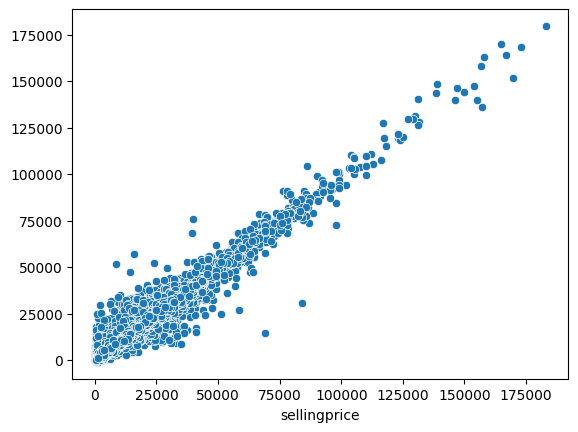

In [157]:
# evaluating our model's performance
# lets visualize this
sns.scatterplot(x = y_test, y = prediction)

In [158]:
mean_absolute_error(y_test,prediction)

1038.2895253767597

In [159]:
mean_squared_error(y_test, prediction)

2663984.0294263577

In [160]:
r2_score(y_test, prediction)

0.9710338265536456

In [151]:


#----------------------------- After Accepting user input ----------------------------------------

num_col = [col for col in df.columns if df[col].dtypes in ['int64','float64']]
cat_col = [col for col in df.columns if df[col].dtypes in ['object']]


# engineering the numerical features that have interaction
#1. odometer vs. mmr
#2. mmr vs. condition
df['odo_mmr'] = df['odometer'] * df['mmr'] 
df['mmr_cond'] = df['mmr'] * df['condition']
df['cond_odo'] = df['condition'] * df['odometer']

df2 = df.copy()
encoder = LabelEncoder()
for col in cat_col:
    df2[col] = encoder.fit_transform(df2[col])
    
X = df2.drop(columns=['sellingprice'])
y = df2['sellingprice']

#splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lm = LinearRegression()

In [161]:
import joblib
# Save the pipeline
joblib.dump(lm, 'vehicle_sales_model.pkl')

# Load the pipeline
model = joblib.load('vehicle_sales_model.pkl')

In [162]:
model.predict(X_test)

array([ 4604.73506328, 20750.68430715, 22933.09107039, ...,
        4872.27241818,  5207.59302137,  8522.55047511])

In [163]:
# saving all categorical values as txt file

In [164]:
cat_col

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller']

In [165]:
df.interior.unique()

array(['black', 'beige', 'tan', 'brown', 'gray', 'burgundy', 'white',
       'silver', 'off-white', 'red', 'yellow', 'green', 'purple', 'blue',
       'orange', 'gold'], dtype=object)

In [169]:
for col in categorical_cols:
    # Open a file in write mode
    with open(f"{col}_data.txt", 'w') as file:
        # Write each brand as a separate line in quotes
        for brand in df[col].unique():
            file.write(f"'{brand}'\n")

In [178]:
df.condition.unique()

array([ 5., 45., 41., 43.,  1., 34.,  2., 42.,  3., 48., 49., 17., 19.,
       29., 38., 44., 47., 32.,  4., 25., 37., 39., 31., 28., 46., 35.,
       26., 21., 36., 22., 27., 24., 33., 23., 16., 18., 12., 14., 11.,
       13., 15.])

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440393 entries, 0 to 558836
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440393 non-null  int64  
 1   make          440393 non-null  object 
 2   model         440393 non-null  object 
 3   trim          440393 non-null  object 
 4   body          440393 non-null  object 
 5   transmission  440393 non-null  object 
 6   state         440393 non-null  object 
 7   condition     440393 non-null  float64
 8   odometer      440393 non-null  float64
 9   color         440393 non-null  object 
 10  interior      440393 non-null  object 
 11  seller        440393 non-null  object 
 12  mmr           440393 non-null  float64
 13  sellingprice  440393 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 50.4+ MB


In [179]:
df.odometer.unique()

array([ 16639.,   9393.,   1331., ...,  85155., 262065.,  74996.])

In [174]:
with open('make_data.txt', 'r') as file:
    car_brands_from_file = [line.strip().strip("'") for line in file.readlines()]

car_brands_from_file

['kia',
 'bmw',
 'volvo',
 'nissan',
 'chevrolet',
 'audi',
 'ford',
 'cadillac',
 'acura',
 'lexus',
 'hyundai',
 'buick',
 'infiniti',
 'jeep',
 'mercedes-benz',
 'mitsubishi',
 'mazda',
 'mini',
 'land-rover',
 'lincoln',
 'jaguar',
 'volkswagen',
 'toyota',
 'subaru',
 'scion',
 'porsche',
 'dodge',
 'fiat',
 'chrysler',
 'ferrari',
 'honda',
 'gmc',
 'ram',
 'smart',
 'bentley',
 'pontiac',
 'saturn',
 'maserati',
 'mercury',
 'hummer',
 'saab',
 'suzuki',
 'oldsmobile',
 'rolls-royce',
 'isuzu',
 'tesla',
 'aston-martin',
 'geo',
 'plymouth',
 'fisker',
 'daewoo',
 'lamborghini',
 'lotus']

In [176]:
df['year'].unique()

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000, 1999, 1998, 1996, 1995, 1997, 1994,
       1993, 1992, 1991, 1990], dtype=int64)

In [177]:
with open(f"year_data.txt", 'w') as file:
    # Write each brand as a separate line in quotes
    for year in df['year'].unique():
        file.write(f"'{year}'\n")

In [167]:
df.seller.nunique()

11777

In [197]:
with open("make_data.txt", "r") as file:
    for cars in file:
        cars = [line.strip() for line in file.readlines()]
        print(cars)

["'lexus' 'hyundai' 'buick' 'infiniti' 'jeep' 'mercedes-benz' 'mitsubishi'", "'mazda' 'mini' 'land-rover' 'lincoln' 'jaguar' 'volkswagen' 'toyota'", "'subaru' 'scion' 'porsche' 'dodge' 'fiat' 'chrysler' 'ferrari' 'honda'", "'gmc' 'ram' 'smart' 'bentley' 'pontiac' 'saturn' 'maserati' 'mercury'", "'hummer' 'saab' 'suzuki' 'oldsmobile' 'rolls-royce' 'isuzu' 'plymouth'", "'tesla' 'aston-martin' 'geo' 'fisker' 'daewoo' 'lamborghini' 'lotus']"]


In [196]:
values

" 'tesla' 'aston-martin' 'geo' 'fisker' 'daewoo' 'lamborghini' 'lotus']"